#**Import packages**

In [ ]:
%env SCIPY_ARRAY_API=1
import pandas as pd
import numpy as np
import requests
import zipfile
from io import BytesIO
!pip install combat
!pip install combat --upgrade
!pip install inmoose
from inmoose.pycombat import pycombat_norm, pycombat_seq
from combat.pycombat import pycombat
from sklearn.model_selection import train_test_split
!pip install conorm
import conorm as conorm
from sklearn.preprocessing import LabelEncoder
from conorm import tmm_norm_factors
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
!pip install rnanorm
!pip install mrmr_selection
from mrmr import mrmr_classif
!pip install imbalanced-learn
import os
import random
import numpy as np
seed = 40
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

#**Load data**

In [ ]:
sample_url = "https://raw.githubusercontent.com/MyronBest/InTVeld_Pancancer_TSOO/main/TableS2.csv"

sampleinfo = pd.read_csv(sample_url)
sampleinfo.drop('Unnamed: 0', axis=1, inplace=True)

sampleinfo=sampleinfo[(sampleinfo['Group']=='Ovarian cancer')|(sampleinfo['Group']=='Asymptomatic controls')]

sampleinfo=sampleinfo.loc[sampleinfo['Sex']=='F']

sampleinfo = sampleinfo[~((sampleinfo['Group'] == 'Ovarian cancer') & (sampleinfo['Stage'] == 'n.a.'))]

sampleinfo['Stage']=sampleinfo['Stage'].replace(to_replace='n.a.',value='Control')


In [ ]:
order = ["Institute 1", "Institute 2", "Institute 3", "Institute 4", "Institute 5",
                "Institute 10", "Institute 12", "Institute 13"]

sampleinfo = sampleinfo.sort_values(by="Sample.supplying.institution").reset_index(drop=True)

Samples=sampleinfo['Sample.ID'].tolist()

In [ ]:
!pip install pyreadr
import pyreadr
import requests
import io
import tempfile

reads="https://raw.githubusercontent.com/ComputationalBiologyLab/TEP_Ovarian-Cancer/main/dat/GSE183635_TEP_Count_Matrix.RData"

response = requests.get(reads)
response.raise_for_status()
with tempfile.NamedTemporaryFile(suffix=".RData") as tmp:
    tmp.write(response.content)
    tmp.flush()
    result = pyreadr.read_r(tmp.name)

counts=list(result.values())[0]
print(counts.shape)

In [ ]:
genes="https://raw.githubusercontent.com/ComputationalBiologyLab/TEP_Ovarian-Cancer/main/dat/dgeGenesEnsembl75.RData"

response = requests.get(genes)
response.raise_for_status()
with tempfile.NamedTemporaryFile(suffix=".RData") as tmp:
    tmp.write(response.content)
    tmp.flush()
    result = pyreadr.read_r(tmp.name)

genes=list(result.values())[0]
genes.index.name = None
print(genes.shape)

In [ ]:
counts.columns = counts.columns.str.replace(r'^.*?-', '', regex=True)
counts=counts[Samples]
y_genes=genes[genes['chromosome_name']=='Y']
y_genes=y_genes['ensembl_gene_id'].tolist()
print(len(y_genes))
genes_in_counts=counts.index.tolist()
matching_y = list(set(y_genes).intersection(genes_in_counts))
counts=counts.drop(matching_y)
print(counts.shape)

In [ ]:
genes.set_index(genes['ensembl_gene_id'], inplace=False)
genes_in_counts=counts.index.tolist()
mask = genes['ensembl_gene_id'].isin(genes_in_counts)
genes_in_counts=genes[mask]

In [ ]:
print(genes_in_counts.shape)
print(counts.shape)

#**RLE plot before batch correction**

In [ ]:
RLE=counts.copy()
medians=RLE.median(axis=1)
RLE=np.log2(RLE + 1).sub(np.log2(medians + 1), axis=0)
plt.figure(figsize=(15,15))
sns.boxplot(data=RLE, showfliers=False)
plt.ylabel("Relative Log Expression (RLE)")
plt.title("RLE before batch correction")
plt.xticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.tight_layout()
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.show()

#**Batch Effect Correction**

InMoose provides features to correct technical biases, also called batch effects, in transcriptomic data:

***for microarray data***,
InMoose supersedes pyCombat [1], a Python 3 implementation of ComBat [2], one of the most widely used tool for batch effect correction on microarray data.

***for RNASeq***, InMoose features a port to Python3 of ComBat-Seq [3], one of the most widely used tool for batch effect correction on RNASeq data.
To use these functions, simply import them and call them with default parameters:

`from inmoose.pycombat import pycombat_norm, pycombat_seq`

`microarray_corrected = pycombat_norm(microarray_data, microarray_batches)`

`rnaseq_corrected = pycombat_seq(rnaseq_data, rnaseq_batches)`


#**microarray_data, rnaseq_data:**
the expression matrices, containing the information about the gene expression (rows) for each sample (columns).

#**microarray_batches, rnaseq_batches:**
list of batch indices, describing the batch for each sample. The list of batches should contain as many elements as the number of samples in the expression matrix.


**##ComBat-seq and pyComBat (pycombat_seq)**
both work on data that follow a negative binomial distribution, which is the distribution of raw counts in RNA-Seq data. No preprocessing of the raw counts is thus needed.
https://doi.org/10.1186/s12859-023-05578-5

In [ ]:
corrected = pycombat_seq(counts, sampleinfo['Sample.supplying.institution'])
corrected=pd.DataFrame(corrected, columns=Samples, index=genes_in_counts['ensembl_gene_id'])
corrected=corrected.transpose()


In [ ]:
from rnanorm import TMM
tmm = TMM().fit(corrected)
tmm.get_norm_factors(corrected)
norm=tmm.transform(corrected)
norm=pd.DataFrame(data=norm, columns=genes_in_counts['ensembl_gene_id'])
Encoder=LabelEncoder()
norm.insert(5434, 'Stage', value=sampleinfo['Stage'])
norm['Stage']=Encoder.fit_transform(norm['Stage'])

#**RLE plot after batch correction**

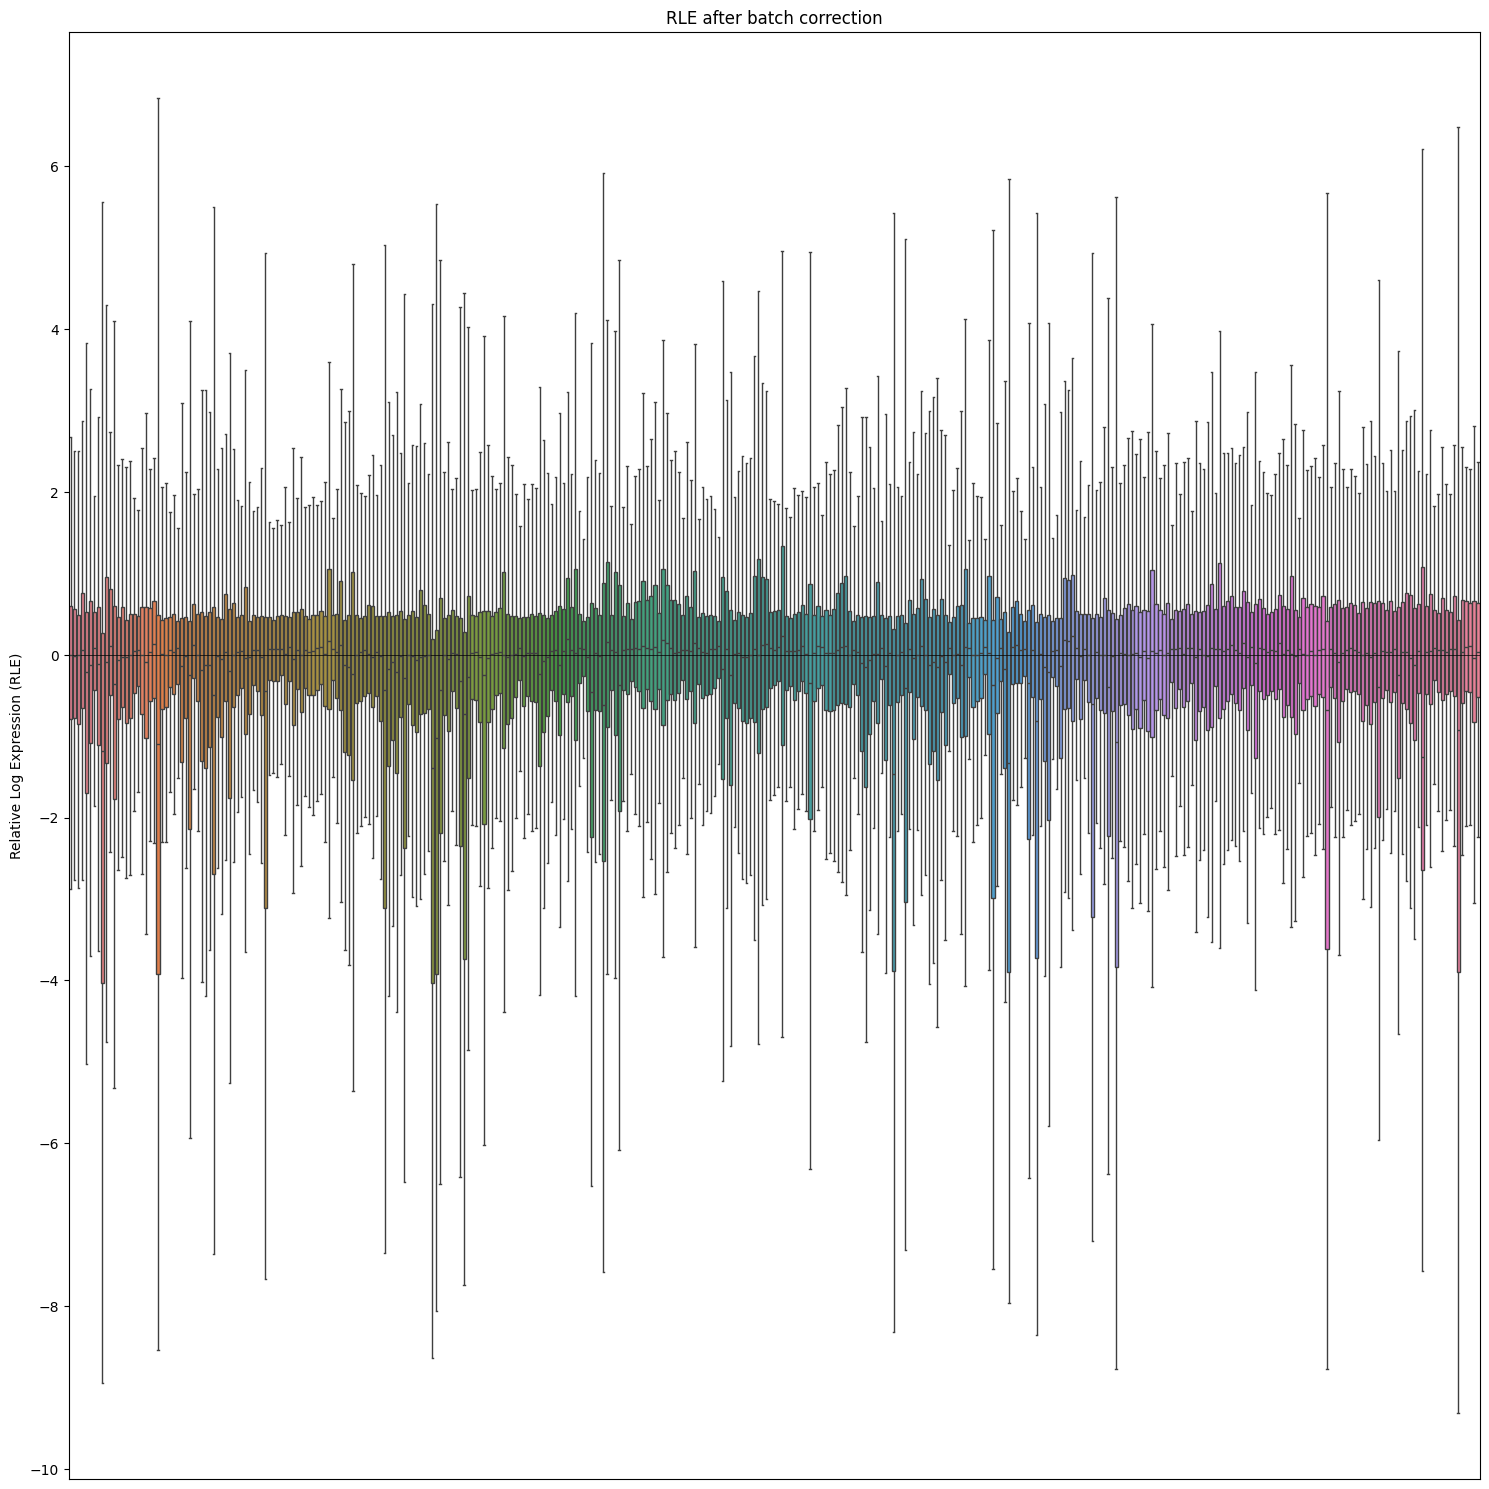

In [ ]:
RLE=norm.iloc[:, :-1].transpose()
medians=RLE.median(axis=1)
RLE=np.log2(RLE + 1).sub(np.log2(medians + 1), axis=0)
plt.figure(figsize=(15,15))
sns.boxplot(data=RLE, showfliers=False)
plt.ylabel("Relative Log Expression (RLE)")
plt.title("RLE after batch correction")
plt.xticks([])
plt.gca().xaxis.set_ticks_position('none')
plt.tight_layout()
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.show()

#**Apply variance threshold**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
selector.fit_transform(norm.iloc[:,:-1])
selector.get_support()
var_selected=list(selector.get_feature_names_out())
var_selected=norm.loc[:,var_selected]
var_selected.set_index(sampleinfo['Sample.ID'],inplace=True)

#**Split and transform Labels**

In [ ]:
StageII_samples=sampleinfo.copy()
StageII_samples['Stage'] = StageII_samples['Stage'].replace(['I', 'III', 'IV'], 'rest')
StageII_samples=StageII_samples[StageII_samples['Stage'] != 'rest']
StageII_IDs=StageII_samples['Sample.ID'].tolist()
StageII_samples['Stage']=Encoder.fit_transform(StageII_samples['Stage'])
y=StageII_samples['Stage'].to_numpy()
X=var_selected.loc[StageII_IDs].to_numpy()


#**Stage 2 versus control**

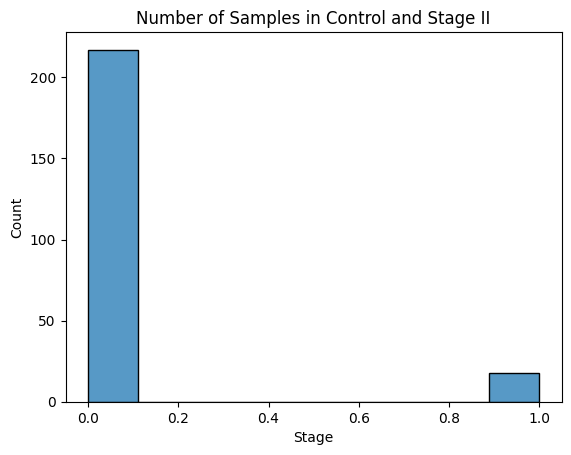

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(StageII_samples['Stage'])
plt.title('Number of Samples in Control and Stage II')
plt.show()

In [ ]:
print(X.shape)
classes, counts = np.unique(y, return_counts=True)
print(f"classes: {classes}")
print(f"Counts: {counts}")

(235, 5434)
classes: [0 1]
Counts: [217  18]


#**Apply SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler()
sm = SMOTE(random_state=40, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.1, random_state=40, stratify=y_res)
X_train=Scaler.fit_transform(X_train)
X_test=Scaler.transform(X_test)


In [ ]:
print(X_res.shape)
classes, counts = np.unique(y_res, return_counts=True)
print(f"classes: {classes}")
print(f"Counts: {counts}")

(434, 5434)
classes: [0 1]
Counts: [217 217]


#**SelectFromModel-SVM**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LinearSVC(random_state=40), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

LinearSVC(C=0.01, random_state=40)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
SVC=LinearSVC(C=0.01, class_weight='balanced', random_state=40)
SVC.fit(X_train, y_train)
sfm = SelectFromModel(SVC, prefit=True, max_features=500)
sfm_selected=sfm.get_support(indices=True)
sfm_selected=[var_selected.columns[i] for i in sfm_selected]
print(len(sfm_selected))


500


In [ ]:
import pandas as pd

In [ ]:
url = "https://raw.githubusercontent.com/ShaimaaGG/Machine-learning-course/main/dat/Differential_exp_results.xlsx"
DEGs = pd.read_excel(url, sheet_name="AUC_validation_dataset")
DEGs=DEGs[DEGs['Stage'] == 'Stage2']
DEGs=DEGs['ensembl_gene_id'].tolist()
common= list(set(DEGs).intersection(sfm_selected))
print("Common items:", len(common))



Common items: ['ENSG00000140105', 'ENSG00000131725', 'ENSG00000137752', 'ENSG00000168906', 'ENSG00000178537', 'ENSG00000164024', 'ENSG00000172543', 'ENSG00000145907', 'ENSG00000073969', 'ENSG00000185909', 'ENSG00000213465', 'ENSG00000132405', 'ENSG00000069493', 'ENSG00000153395', 'ENSG00000116260', 'ENSG00000165609', 'ENSG00000196843', 'ENSG00000108854', 'ENSG00000184708', 'ENSG00000118007']
20


#**Venn Diagrm**

In [ ]:
!pip install matplotlib-venn matplotlib
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
!pip install venny4py

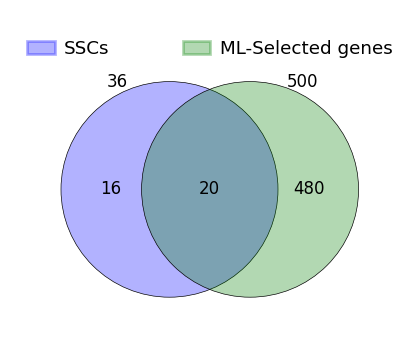

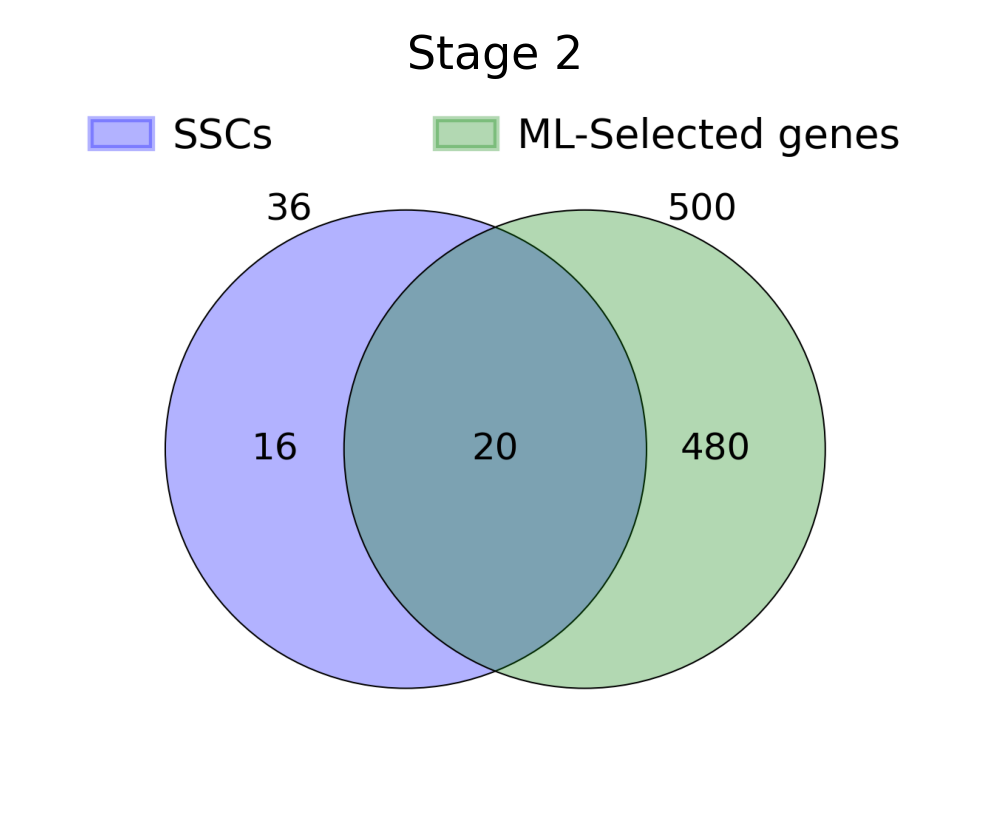

In [ ]:
from venny4py.venny4py import venny4py
import matplotlib.pyplot as plt
from PIL import Image

DEGs = set(DEGs)
sfm_selected = set(sfm_selected)

sets = {
    'SSCs': DEGs,
    'ML-Selected genes': sfm_selected
}


venny4py(sets=sets, size=2, dpi=600, out='Stage 2', ext='png', font_size=6)

img = Image.open("/content/Stage 2/Venn_2.png")

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
ax.imshow(img)
ax.axis('off')
ax.text(0.5, 0.95, 'Stage 2', transform=ax.transAxes, ha='center', fontsize=11)


plt.savefig("Stage_2.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
X=var_selected.loc[StageII_IDs, common].to_numpy()
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler()
sm = SMOTE(random_state=40, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.1, random_state=40, stratify=y_res)
X_train=Scaler.fit_transform(X_train)
X_test=Scaler.transform(X_test)

#**Test on RF**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 50],
    'min_samples_split': [2, 5, 10]
}

RF = RandomForestClassifier(random_state=40)

grid_search = GridSearchCV(RF, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=40)


In [ ]:
RF=RandomForestClassifier(max_depth=10, n_estimators=50, random_state=40)
RF=RF.fit(X_train, y_train)
print(accuracy_score(y_train, RF.predict(X_train)))
print(accuracy_score(y_test, RF.predict(X_test)))

1.0
0.9772727272727273


In [ ]:
from sklearn.metrics import accuracy_score, precision_score,classification_report ,recall_score, f1_score, confusion_matrix
y_test_pred = RF.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print(classification_report(y_test, y_test_pred))

Accuracy: 0.98
Precision: 0.96
Recall: 1.00
F1 Score: 0.98

Confusion Matrix:
[[21  1]
 [ 0 22]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.96      1.00      0.98        22

    accuracy                           0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



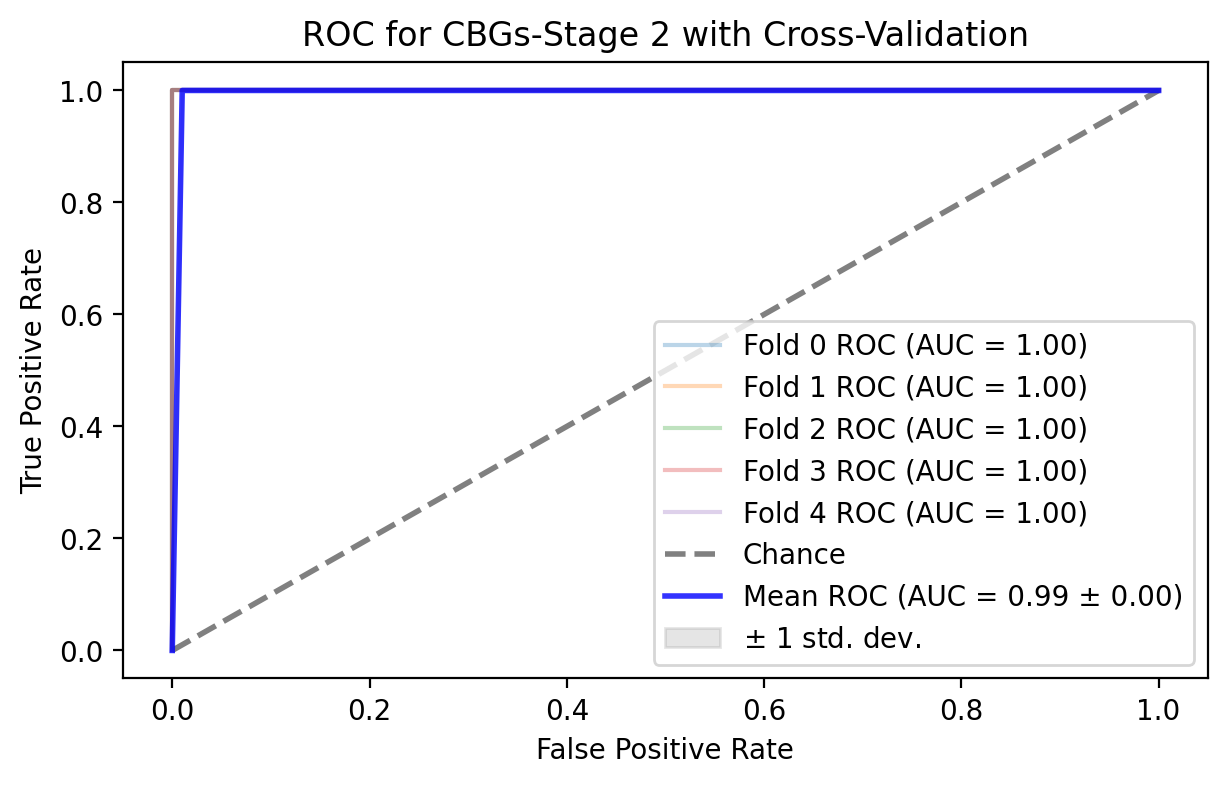

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize the model
RF = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=40)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Variables to store results
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Perform cross-validation
for i, (train_idx, test_idx) in enumerate(cv.split(X_res, y_res)):
    # Split data
    X_train, X_test = X_res[train_idx], X_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]

    # Fit the model
    RF.fit(X_train, y_train)

    # Get probabilities for the positive class
    y_test_proba = RF.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate true positive rates
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Plot the ROC curve for this fold
    ax.plot(fpr, tpr, alpha=0.3, label=f"Fold {i} ROC (AUC = {roc_auc:.2f})")

# Plot the chance line
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance", lw=2)

# Calculate and plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f ± %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

# Fill between the standard deviation bounds
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="gray",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

# Customize plot
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for CBGs-Stage 2 with Cross-Validation",
)
ax.legend(loc="lower right")
plt.savefig("ROC_2.png", dpi=1000)
plt.show()



In [ ]:
ML2 = pd.DataFrame(common, columns=['ensembl_gene_id'])
ML2['Stage'] = 'Stage2'
ML2.to_csv('ML2.csv', index=False)